In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import astropy.units as u
import astropy.constants as c

from astropy.coordinates import SkyCoord
from astropy.time import Time

import pandas as pd                          # I/O of data in table format
from astroquery.jplhorizons import Horizons  # python interface to HORIZONS

from tqdm.autonotebook import tqdm as tqdm

from scipy.interpolate import interp1d



/tmp/ipykernel_468944/4169885227.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd                          # I/O of data in table format
/tmp/ipykernel_468944/4169885227.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm as tqdm


In [2]:
data_path = './'
scw_file = 'ScwDB_reduced_0016-2704.fits'# Housekeeping file, containing all the data that we need from Integral.


In [3]:
#Getting the info from the file
scw = fits.open(data_path+scw_file)
scw.info()

Filename: ./ScwDB_reduced_0016-2704.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     76   194801R x 26C   [12A, 1I, 1I, 1I, 1I, 20A, 20A, 4I, 4I, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 4D, 1D]   


In [20]:
# looking into the pointing distribution:
ra_sc = scw[1].data['RA_SCX']
dec_sc = scw[1].data['DEC_SCX']
# creating coordinate objects for each of the observations
coords_sc = SkyCoord(ra=ra_sc,dec=dec_sc,unit='deg')

# converting the coordinates from ra/dec to Galactic longitude/latitude:
lon_sc = coords_sc.galactic.l.value
# converting from 0..360 to -180..180
lon_sc[lon_sc > 180] -= 360
lat_sc = coords_sc.galactic.b.value
revs = scw[1].data['OrbitRevFrac']
revs_unit = scw[1].columns['OrbitRevFrac'].unit

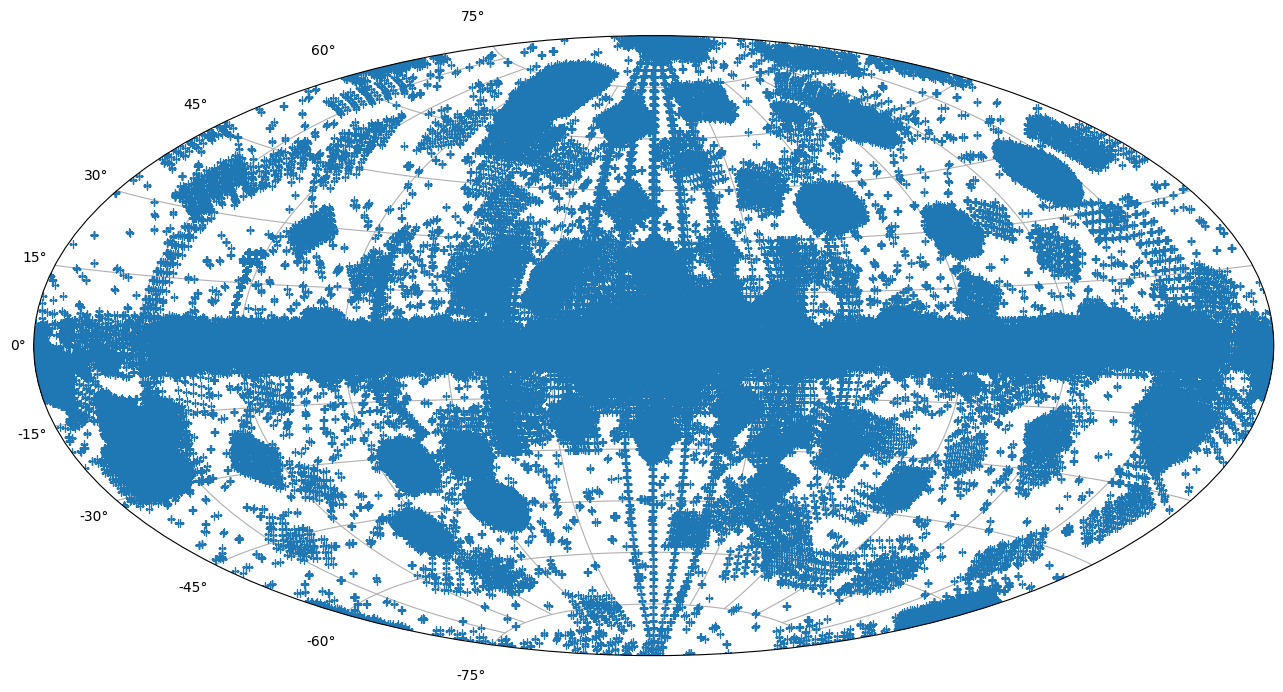

In [6]:
# plotting the coordinates
plt.figure(figsize=(16,10))
plt.subplot(projection='aitoff')
plt.plot(np.deg2rad(lon_sc),np.deg2rad(lat_sc),'+')
plt.grid()

In [35]:
# Now we want to see which of the pointings are in the area where the object we want to study is located.
# We set the fov of SPI equal to 16
fov_threshold = 16.

# We also need to calculate the angular distance of each pointing to the object. We do this using:
# we need to calculate the angular distance of each pointing to the Crab, which
# can be done by the following functions

def GreatCircle(l1,b1,l2,b2,deg=True):

    if deg == True:
        l1,b1,l2,b2 = np.deg2rad(l1),np.deg2rad(b1),np.deg2rad(l2),np.deg2rad(b2)

    return np.sin(b1)*np.sin(b2) + np.cos(b1)*np.cos(b2)*np.cos(l1-l2)



def angular_distance(l1,b1,l2,b2,deg=True):
    """
    Calculate angular distance on a sphere from longitude/latitude pairs to other using Great circles
    """
    gc = GreatCircle(l1,b1,l2,b2,deg=deg)

    if gc.size == 1:
        if gc > 1:
            gc = 1.
    else:
        gc[np.where(gc > 1)] = 1.

    return np.rad2deg(np.arccos(gc))

In [36]:
# Now to find which pointing see Jupiter we nee to find the position of Jupiter in the requested time period.
# We get the coordinates from:
obj = Horizons(id='5',id_type='majorbody', 
               location='500@-198',        
               epochs={'start':'2002-10-18',
                       'stop':'2023-12-31', 
                       'step':'6h'})

In [7]:
jupiter_eph = obj.ephemerides()
jupiter_eph_df = jupiter_eph.to_pandas()# Converting the data obtained above to a pandas database
jupiter_eph_df

,targetname,datetime_str,datetime_jd,solar_presence,flags,RA,DEC,RA_app,DEC_app,RA_rate,...,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
0,Jupiter Barycenter (5),2002-Oct-18 00:00,2452565.50,,,137.27188,16.91116,137.27012,16.91179,18.68949,...,<NA>,<NA>,<NA>,<NA>,<NA>,108.4643,<NA>,10.2035,129.5536,0.5146
1,Jupiter Barycenter (5),2002-Oct-18 06:00,2452565.75,,,137.30459,16.90143,137.30280,16.90199,18.86299,...,<NA>,<NA>,<NA>,<NA>,<NA>,108.4846,<NA>,10.2161,129.5801,0.5147
2,Jupiter Barycenter (5),2002-Oct-18 12:00,2452566.00,,,137.33758,16.89212,137.33576,16.89263,19.00977,...,<NA>,<NA>,<NA>,<NA>,<NA>,108.5048,<NA>,10.2288,129.6066,0.5151
3,Jupiter Barycenter (5),2002-Oct-18 18:00,2452566.25,,,137.37082,16.88320,137.36897,16.88366,19.15180,...,<NA>,<NA>,<NA>,<NA>,<NA>,108.5251,<NA>,10.2417,129.6332,0.5157
4,Jupiter Barycenter (5),2002-Oct-19 00:00,2452566.50,,,137.40431,16.87468,137.40243,16.87509,19.30801,...,<NA>,<NA>,<NA>,<NA>,<NA>,108.5453,<NA>,10.2546,129.6599,0.5166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30972,Jupiter Barycenter (5),2023-Dec-30 00:00,2460308.50,,,33.36533,12.13503,33.36797,12.13622,-0.96268,...,<NA>,<NA>,<NA>,<NA>,<NA>,30.7421,<NA>,10.0718,40.2809,-1.1416
30973,Jupiter Barycenter (5),2023-Dec-30 06:00,2460308.75,,,33.36383,12.13288,33.36644,12.13391,-0.79978,...,<NA>,<NA>,<NA>,<NA>,<NA>,30.7644,<NA>,10.0966,40.2912,-1.1422
30974,Jupiter Barycenter (5),2023-Dec-30 12:00,2460309.00,,,33.36260,12.13199,33.36518,12.13291,-0.64499,...,<NA>,<NA>,<NA>,<NA>,<NA>,30.7868,<NA>,10.1206,40.3017,-1.1423
30975,Jupiter Barycenter (5),2023-Dec-30 18:00,2460309.25,,,33.36163,12.13204,33.36419,12.13287,-0.49338,...,<NA>,<NA>,<NA>,<NA>,<NA>,30.8091,<NA>,10.1441,40.3126,-1.1420


In [37]:

#Getting the relevant coordinates and dates for these coordinates for Jupiter in the requested time span

gl_jupiter = jupiter_eph_df['GlxLon'].values # galactic longtitude
gl_jupiter[gl_jupiter>180] -= 360
gb_jupiter = jupiter_eph_df['GlxLat'].values # galactic latitude
jd_jupiter = jupiter_eph_df['datetime_jd'].values # dates and time for the position
ra_jupiter = jupiter_eph_df['RA'].values # right ascension
dec_jupiter = jupiter_eph_df['DEC'].values # declination

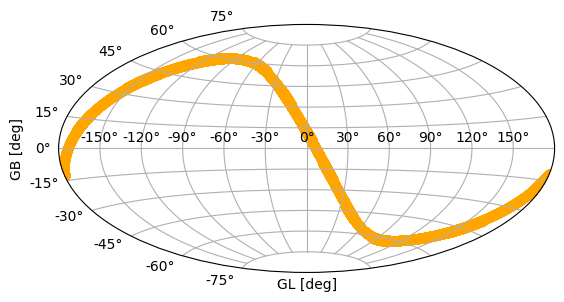

In [38]:
# Plotting the coordinates

plt.subplot(projection='aitoff')
plt.scatter(np.deg2rad(gl_jupiter),np.deg2rad(gb_jupiter),marker='o', c='orange')
plt.xlabel('GL [deg]')
plt.ylabel('GB [deg]')
plt.grid()

In [39]:
# creating a Time object to convert times easily
times_jupiter = Time(jd_jupiter,format='jd')

# converting to MJD:
times_jupiter_mjd = times_jupiter.mjd

# converting to IJD
times_jupiter_ijd = times_jupiter_mjd - 51544
print(times_jupiter_ijd)



[1021.   1021.25 1021.5  ... 8764.5  8764.75 8765.  ]


In [40]:
# getting scw times:
tstart_scw = scw[1].data['TStart']
tend_scw = scw[1].data['TEnd']

n_scw = len(tstart_scw)


valid_times = np.where((tstart_scw >= times_jupiter_ijd.min()) & (tstart_scw <= times_jupiter_ijd.max()))

# Perform linear interpolation 
interp_longitude = interp1d(times_jupiter_ijd, gl_jupiter, kind='linear')
interp_latitude = interp1d(times_jupiter_ijd, gb_jupiter, kind='linear')

# Interpolate Jupiter positions for each INTEGRAL observation timestamp
interp_gl = interp_longitude(tstart_scw[valid_times])
interp_gb = interp_latitude(tstart_scw[valid_times])

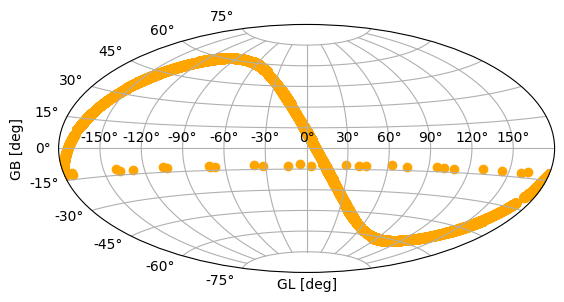

In [12]:
# Plotting the positions

plt.subplot(projection='aitoff')
plt.scatter(np.deg2rad(interp_gl),np.deg2rad(interp_gb),marker='o', c='orange')
plt.xlabel('GL [deg]')
plt.ylabel('GB [deg]')
plt.grid()

In [41]:

jupiter_cross_idx = []

# length of scw file (number of observations)
n_scw = len(tstart_scw)

# length of calculated jupiter positions
n_jupiter = len(interp_gb)

print(n_jupiter)

for i in tqdm(range(n_jupiter)):
         if angular_distance(lon_sc[i],lat_sc[i], interp_gl[i], interp_gb[i]) <= fov_threshold:
                jupiter_cross_idx.append(i)
                
len(jupiter_cross_idx)

194801


100%|██████████| 194801/194801 [00:02<00:00, 90514.14it/s]


5331

In [42]:
def filter_pointings_for_jupiter(scw_file, jupiter_positions, threshold, new_filename, overwrite=True):
    f = fits.open(scw_file)
    cs_f = []
    for col_name in f[1].columns.names:
        c_tmp = fits.Column(name=col_name,
                            array=f[1].data[col_name][jupiter_cross_idx],
                            format=f[1].columns[col_name].format,
                            unit=f[1].columns[col_name].unit)
        cs_f.append(c_tmp)
    # Write filtered pointings to a new file
    t_f = fits.BinTableHDU.from_columns(cs_f)
    t_f.writeto(new_filename, overwrite=overwrite)

    f.close()
    

In [43]:
filter_pointings_for_jupiter(data_path+scw_file,jupiter_cross_idx,16,data_path+'scw_Jupiter_obs.fits')

In [44]:
# now reading the just-created file in again to see what is the result
scw_Jupiter = fits.open(data_path+'scw_Jupiter_obs.fits')

In [45]:
ra_sc_new = scw_Jupiter[1].data['RA_SCX']
dec_sc_new = scw_Jupiter[1].data['DEC_SCX']

coords_sc_new = SkyCoord(ra=ra_sc_new,dec=dec_sc_new,unit='deg')

lon_sc_new = coords_sc_new.galactic.l.value
lon_sc_new[lon_sc_new > 180] -= 360
lat_sc_new = coords_sc_new.galactic.b.value

In [18]:
plt.figure(figsize=(16, 10))
plt.subplot(projection='aitoff')

# Plot all pointings
plt.plot(np.deg2rad(lon_sc), np.deg2rad(lat_sc), '+', label='All Pointings')

# Plot chosen pointings coinciding with Jupiter
plt.plot(np.deg2rad(lon_sc_new), np.deg2rad(lat_sc_new), 'r+', label='Chosen Jupiter Pointings')

# Plot Jupiter position (for reference)
plt.plot(np.deg2rad(gl_jupiter), np.deg2rad(gb_jupiter), 'y*', label='Jupiter', zorder=100, markersize=10)
plt.legend(loc=1)
plt.grid()

plt.show()

: 

In [46]:
# Now that we have the pointings that can see Jupiter we will need to consider that Jupiter might be very weak,
# so that we will try to avoid bright sources; Thus we will remove the pointings near the galactic center and the anti-galactic center.
#The anti-galactic center is the crab nebula so we need to find where it is and remove the pointings that are within 30 deg of the Crab. 
# The same will happen for the galactic-center.

l_Crab, b_Crab = 184.5574843227357-360, -05.7843392171240 #position of the crab.

scw_filtered = fits.open(data_path+"scw_Jupiter_obs.fits")
scw_filtered.info()

# looking into the pointing distribution:
ra_sc_f = scw_filtered[1].data['RA_SCX']
dec_sc_f = scw_filtered[1].data['DEC_SCX']
# creating coordinate objects for each of the observations
coords_sc_f = SkyCoord(ra=ra_sc_f,dec=dec_sc_f,unit='deg')

# converting the coordinates from ra/dec to Galactic longitude/latitude:
lon_sc_f = coords_sc_f.galactic.l.value
# converting from 0..360 to -180..180
lon_sc_f[lon_sc_f > 180] -= 360
lat_sc_f = coords_sc_f.galactic.b.value
revs_f = scw_filtered[1].data['OrbitRevFrac']
revs_unit_f = scw_filtered[1].columns['OrbitRevFrac'].unit


crab_dist = angular_distance(l_Crab,b_Crab,lon_sc_f,lat_sc_f) #all crab angular distances.
print(crab_dist)

Filename: ./scw_Jupiter_obs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     76   5331R x 26C   [12A, 1I, 1I, 1I, 1I, 20A, 20A, 4I, 4I, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 4D, 1D]   


[57.00532941 56.97678496 56.97479811 ... 69.87919348 27.7051645
 27.66756574]


Text(0, 0.5, 'Angular distance to Crab [deg]')

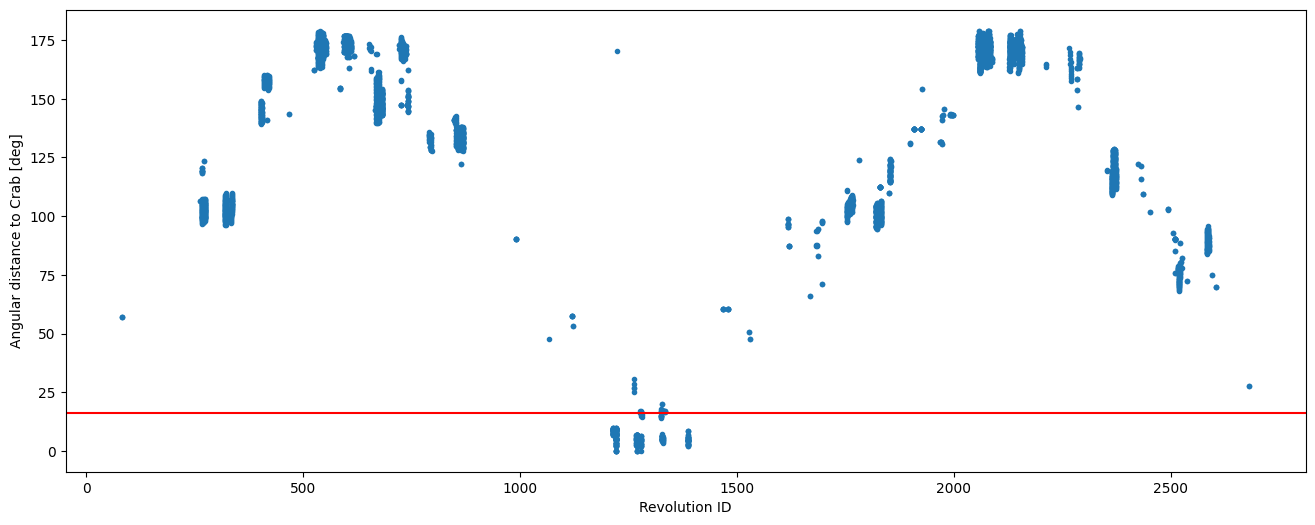

In [48]:
plt.figure(figsize=(16,6))
plt.plot(revs_f,crab_dist,'.')
plt.axhline(fov_threshold,linestyle='-',color='red')
plt.xlabel('Revolution ID')
plt.ylabel('Angular distance to Crab [deg]')

In [50]:
crab_obs_idx = np.where(crab_dist > 30)[0]

def filter_scw(scw_file,filter_idx,new_filename,overwrite=True):

    f = fits.open(scw_file)
    
    used_columns = []
    for i in range(len(f[1].columns)):
        used_columns.append(f[1].columns[i].name)
    
    cs_f = []
    for i in range(len(used_columns)):

        c_tmp = fits.Column(name=used_columns[i],
                            array=f[1].data[used_columns[i]][filter_idx],
                            format=f[1].columns[used_columns[i]].format,
                            unit=f[1].columns[used_columns[i]].unit)

        cs_f.append(c_tmp)
        
    t_f = fits.BinTableHDU.from_columns(cs_f)
    t_f.writeto(new_filename,overwrite=overwrite)
    
    f.close()


In [51]:
filter_scw(data_path+"scw_Jupiter_obs.fits",crab_obs_idx,data_path+'scw_Jupiter_obs_minusCrab.fits')

In [54]:
swc_minusC =fits.open(data_path+'scw_Jupiter_obs_minusCrab.fits')


ra_sc_mC = swc_minusC[1].data['RA_SCX']
dec_sc_mC = swc_minusC[1].data['DEC_SCX']

coords_sc_mC = SkyCoord(ra=ra_sc_mC,dec=dec_sc_mC,unit='deg')

lon_sc_mC = coords_sc_mC.galactic.l.value
lon_sc_mC[lon_sc_mC > 180] -= 360
lat_sc_mC = coords_sc_mC.galactic.b.value

In [55]:
plt.figure(figsize=(16,10))
plt.subplot(projection='aitoff')
plt.plot(np.deg2rad(lon_sc),np.deg2rad(lat_sc),'+',label='All Pointings')
plt.plot(np.deg2rad(lon_sc_mC),np.deg2rad(lat_sc_mC),'r+',label='Filtered Without the Crab')
plt.plot(np.deg2rad(l_Crab),np.deg2rad(b_Crab),'y*',label='Crab',zorder=100,markersize=10)
plt.legend(loc=1)
plt.grid()

NameError: name 'lat_sc_mc' is not defined

: 